In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from scipy import stats

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator


<p style="border:3px #ff0000  solid;">
Задание: 

        Датасет для определения риска сердечного приступа. 
        Необходимо проанализировать и предсказать, подвержен ли человек сердечному приступу или нет.

<p style="border:3px #ff0000  solid;">
1. Загрузка и предобработка данных

In [2]:
heart_df = pd.read_csv('C:/Users/Z/PycharmProjects/data_science_1t/final_task/heart.csv')

<p style="border:3px #ff0000  solid;">
2. Описательный анализ данных, просмотр данных и вывод статистики

In [3]:
heart_df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


    Всего в датафрейме 303 записи (объекта) и 14 признаков.

In [4]:
heart_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


    1. В данных содержится всего лишь 303 записи, что достаточно мало для обучения модели.
    2. Данные не содержат пропусков.
    3. Изменение типов данных не требуется.

In [5]:
#Проверяем наличие дибликатов
heart_df.duplicated().sum()

1

    В представленном датафрейме содержится только одна дублирующася запись, которую необходимо удалить.

In [6]:
heart_df.drop_duplicates(inplace=True)

In [7]:
#Проверим уникальные значения для всех признаков
dict = {}
for i in list(heart_df.columns):
    dict[i] = heart_df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["Уникальные значения"]).transpose()

,Уникальные значения
age,41
sex,2
cp,4
trtbps,49
chol,152
fbs,2
restecg,3
thalachh,91
exng,2
oldpeak,40


In [8]:
#Проверим уникальные значения для категорияальных признаков
for i in list(heart_df.columns):
    if len(heart_df[i].unique()) < 6:
        print(f"{i}_val:", heart_df[i].unique())
        print("\t", heart_df[i].value_counts())
        print()

sex_val: [1 0]
	 sex
1    206
0     96
Name: count, dtype: int64

cp_val: [3 2 1 0]
	 cp
0    143
2     86
1     50
3     23
Name: count, dtype: int64

fbs_val: [1 0]
	 fbs
0    257
1     45
Name: count, dtype: int64

restecg_val: [0 1 2]
	 restecg
1    151
0    147
2      4
Name: count, dtype: int64

exng_val: [0 1]
	 exng
0    203
1     99
Name: count, dtype: int64

slp_val: [0 2 1]
	 slp
2    141
1    140
0     21
Name: count, dtype: int64

caa_val: [0 2 1 3 4]
	 caa
0    175
1     65
2     38
3     20
4      4
Name: count, dtype: int64

thall_val: [1 2 3 0]
	 thall
2    165
3    117
1     18
0      2
Name: count, dtype: int64

output_val: [1 0]
	 output
1    164
0    138
Name: count, dtype: int64



    Датафрейм содержит 9 категориальных признаков, значения которых указанны корректно.
    Во всех признаках имеется значительный дисбаланс классов.

In [9]:
heart_df[["age","trtbps","chol","thalachh","oldpeak"]].describe().T

,count,mean,std,min,25%,50%,75%,max
age,302.0,54.420530,9.047970,29.0,48.00,55.5,61.00,77.0
trtbps,302.0,131.602649,17.563394,94.0,120.00,130.0,140.00,200.0
chol,302.0,246.500000,51.753489,126.0,211.00,240.5,274.75,564.0
thalachh,302.0,149.569536,22.903527,71.0,133.25,152.5,166.00,202.0
oldpeak,302.0,1.043046,1.161452,0.0,0.00,0.8,1.60,6.2


In [10]:
## К'2-тест Д'Агостино для числовых признаков
test = [heart_df.age, heart_df.trtbps, heart_df.chol, heart_df.thalachh, heart_df.oldpeak]
for data in test:
    _, pvalue = stats.normaltest(data)

    alpha = 0.05
    
    print(data.name + ": ")
    if pvalue < alpha:
        print(f'P-value:{pvalue:.5f}. выборка имеет распределение по Гауссу.')
    else:
        print(f'P-value:{pvalue:.5f}. выборка не имеет распределения по Гауссу.')

age: 
P-value:0.01624. выборка имеет распределение по Гауссу.
trtbps: 
P-value:0.00000. выборка имеет распределение по Гауссу.
chol: 
P-value:0.00000. выборка имеет распределение по Гауссу.
thalachh: 
P-value:0.00135. выборка имеет распределение по Гауссу.
oldpeak: 
P-value:0.00000. выборка имеет распределение по Гауссу.


    Все числовые признаки имеют распределение по Гауссу (нормальное распределение).

<p style="border:3px #00B344  solid;">
Вывод по разделу 2:

    В результате проведенного анализа можно сделать вывод, что данные готовы к дальнейшей работе, при этом следует учесть следующие аспекты:
    - имеется дисбаланс классов;
    - количество объектов в датафрейме достаточно маленькое. 

<p style="border:3px #ff0000  solid;">
3. Постройте необходимые графики для анализа

interval columns not set, guessing: ['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh', 'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output']


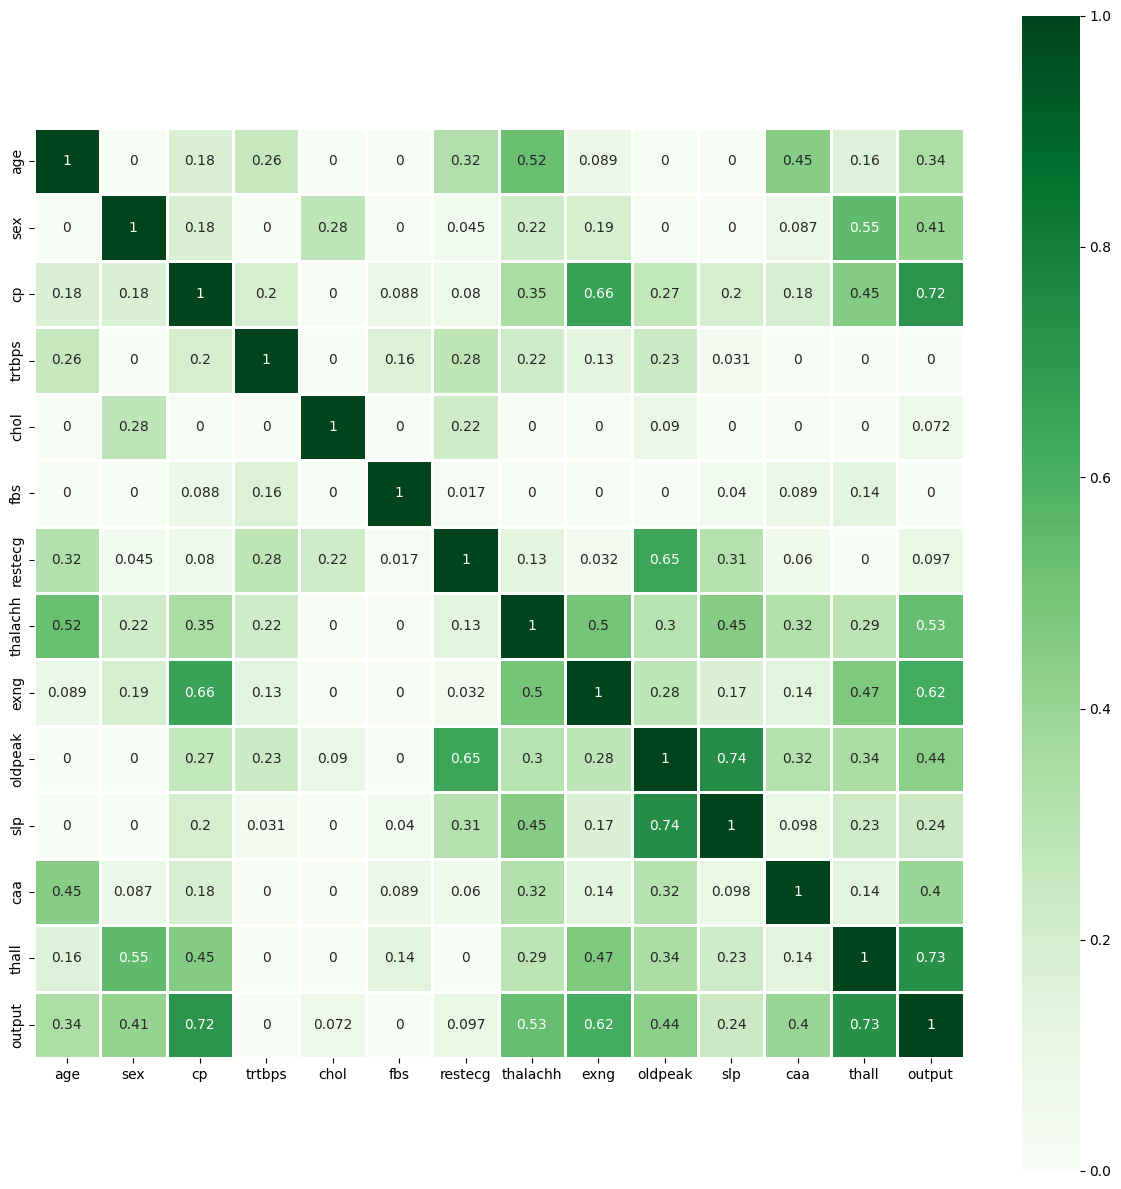

In [11]:
#Построим тепловую карту корреляции `Phik`
tmp = heart_df.phik_matrix()
plt.figure(figsize=(15,15))
sns.heatmap(tmp, annot=True, linewidths=2, cmap='Greens')
plt.imshow(tmp)
plt.show()

    Из представленной тепловой карты следует выделить высокую степень корреляции между следующими признаками:
    - возраст, 

c:\Users\Z\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


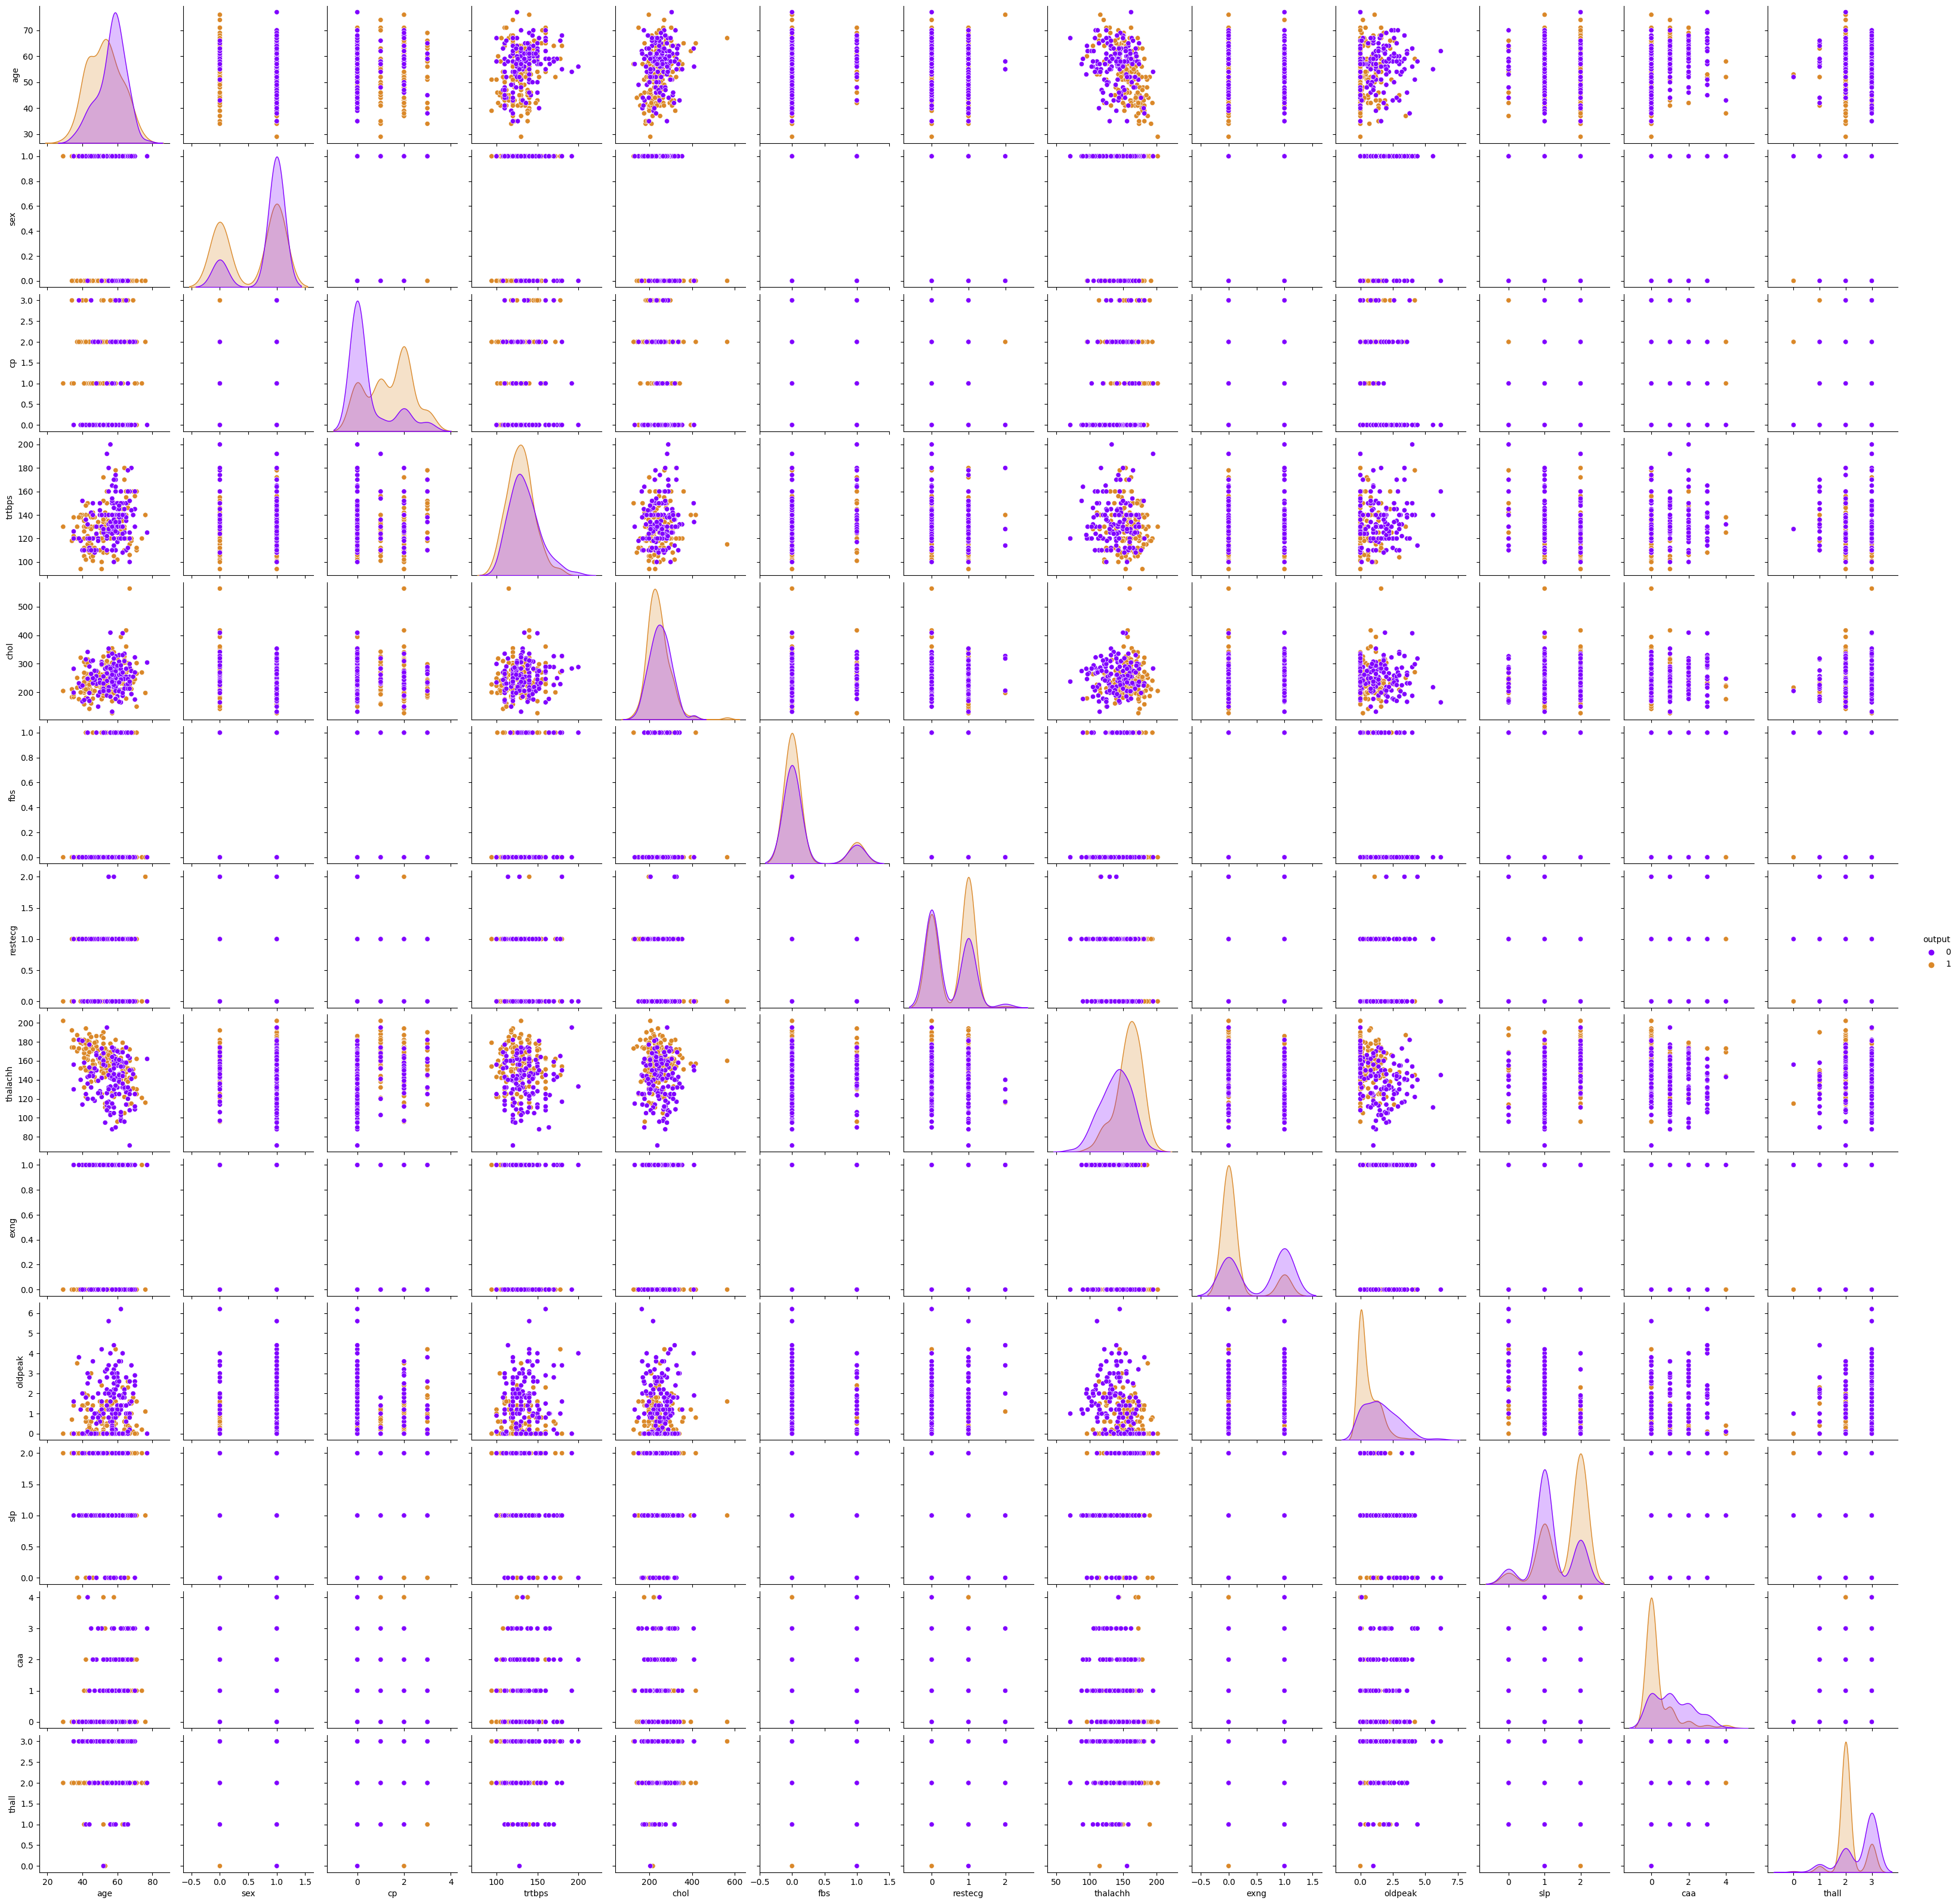

In [12]:
sns.pairplot(heart_df,hue='output',palette = ["#8000ff","#da8829"])
plt.show()

<p style="border:3px #ff0000  solid;">
4. Проверьте гипотезы (если потребуется)

<p style="border:3px #00B344  solid;">
5. Промежуточный отчет-вывод по исследованию

<p style="border:3px #ff0000  solid;">
6. Определите, какую задачу вы будете решать (классификация, регрессия и т.д.)

<p style="border:3px #ff0000  solid;">
7. Создайте несколько моделей для прогнозирования вашего целевого признака и выберите наилучшую, опираясь на вашу валидацию

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 0)

NameError: name 'train_test_split' is not defined

<p style="border:3px #ff0000  solid;">
8. Сделайте прогноз для тестовой выборки (должно быть три выборки в этой задаче: тренировочная, валидационная, тестовая)

<p style="border:3px #ff0000  solid;">
9. Приведите метрику, с помощью которой вы будете оценивать работу вашей модели (обоснуйте ваш выбор метрики)

<p style="border:3px #ff0000  solid;">
10. Сделайте вывод о работе вашей модели и метриках. Обоснуйте: «Нужно ли использовать для решения этой задачи машинное обучение или можно обойтись dummy-предсказанием?»

     1.1 Оберните весь конвейер преобразований в Pipeline

In [ ]:
class MyTransformer(TransformerMixin, BaseEstimator):

    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.get_dummies(X, drop_first=True)
        #X.clolumns = [re.sub('\\.+', '_', i).lower() for i in X.columns]    #Почему-то не работает
        X = self.convert_bool(X)
        X = X.fillna(X.mean())
        X = X.reset_index(drop=True)      
        return X
    
    def convert_bool(self, df):
        bool_column = df.select_dtypes(include=bool).columns
        for column in bool_column:
            df[column] = df[column].astype(int)
        return df

In [ ]:
#Создаем трансформер и преобразуем данные
myTransformer = MyTransformer()
myTransformer.fit(heart_train_df)
heart_train_df = myTransformer.transform(heart_train_df)
heart_test_df = myTransformer.transform(heart_test_df)


In [ ]:
heart_train_df.info()

In [ ]:
heart_test_df.info()

In [ ]:
heart_train_df.HeartDisease.value_counts()

<p style="border:3px #00B344  solid;">
Мы избавились от пропусков. Данные подготовлены к дальнейшей работе. В целевом признаке имеется дисбаланс классов, который необходимо учесть при обучении моделей.
</p>

<p style="border:3px #ff0000  solid;">
2. Подберите оптимальный вариант прогнозной модели с помощью GridSearchCV

    Отделяем признаки

In [ ]:
train_target = heart_train_df['HeartDisease']
train_features = heart_train_df.drop(['HeartDisease'], axis=1)
test_target = heart_test_df['HeartDisease']
test_features = heart_test_df.drop(['HeartDisease'], axis=1)

    Подготовим Pipeline

In [ ]:
pipe = Pipeline([  
  ('ohe_types', MyTransformer()),
  ('scaler', StandardScaler()),
  ('classify', DecisionTreeClassifier(class_weight='balanced', random_state=0))
])

    Подберем оптимальный вариант прогнозной модели с помощью GridSearchCV

In [ ]:
params = [
    {'classify': [LogisticRegression(class_weight='balanced', random_state=0)]}, 
    {'classify': [DecisionTreeClassifier(class_weight='balanced', random_state=0)], 'classify__max_depth': [2, 5, 10, 20]},
    {'classify': [RandomForestClassifier(class_weight='balanced', random_state=0)], 'classify__max_depth': [2, 5, 10, 20], 'classify__n_estimators' : range(10, 51, 10)}
]

grid_search = GridSearchCV(pipe, param_grid=params, cv=5, scoring='roc_auc')
grid_search.fit(X=train_features, y=train_target)
print(
    'Качество модели на тестовой выборке c лучшей моделью:', 
    {roc_auc_score(test_target, grid_search.predict_proba(test_features)[:, 1])}
)

In [ ]:
grid_search.best_estimator_

<p style="border:3px #00B344  solid;">
Выводы:

    1. В результате проведенной работы закреплены знания в оборачивании конвейера преобразований в Pipeline.
    2. Входе исследования обучено три модели, из которых самой эффективной оказалась RandomForestClassifier с параметрами max_depth=20 и n_estimators=50.
    3. Качество модели на тестовой выборке составило 0.91.
    4. Так как в целевом признаке имеется дисбаланс классов, при обучении моделей применялся параметр class_weight='balanced'.